In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import plots
import seaborn as sns
from scipy.signal import savgol_filter  
import warnings
warnings.filterwarnings("ignore")

In [2]:
wd = os.path.dirname(os.getcwd())

In [91]:
country = "CHL"

if country == "ARG":
    country_full = "argentina"
elif country == "CHL":
    country_full = "chile"
elif country == "COL":
    country_full = "colombia"
elif country == "MEX":
    country_full = "mexico"

In [92]:
gdf_admin_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')
gdf_admin_mov = gdf_admin_mov.sort_values(by = ['rdi'], ascending=True).reset_index(drop=True)

In [93]:
fcst_admins = {}

_, _, files = next(os.walk(wd + '/data/outputs/' + country + '/prediction'))
file_count = len(files)-1

for i in range(file_count):
    fcst_admins[str(i)] = pd.read_csv(wd + '/data/outputs/' + country + '/prediction/admin_' + str(i) + '.csv')


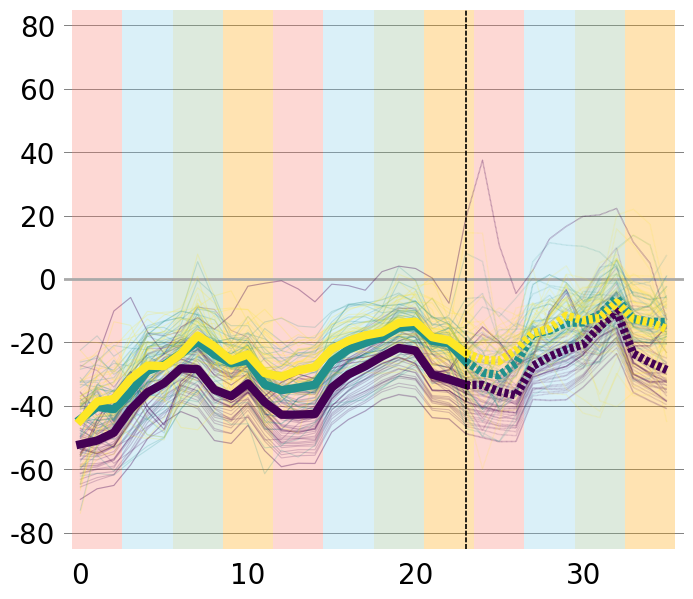

In [94]:
fig,ax = plt.subplots(figsize=(8,7))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

xmin, xmax = -1,36
ax.set_xlim([xmin, xmax])
ymin, ymax = -85, 85
ax.set_ylim([ymin, ymax])

# xticks = []
# xticks_labels = ['April 2020', 'Oct 2020', 'April 2021', 'Oct 2021', 'April 2022']
# for i in range(int(xmin), int(xmax)):
#     if i%6 == 0:
#         xticks.append(i+.25)
# ax.set_xticks(xticks, xticks_labels)
# ax.tick_params(axis = 'x', bottom=True, labelsize = 15, pad=6, rotation=90)
ax.plot([23,23],[ymin,ymax], color='k', lw=1.2, zorder=200, linestyle='--', dashes=(3, 1))
    
yticks = []
for i in range(int(ymin), int(ymax)):
    if i%20 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 20, pad=6, rotation=0)

gdf_admin_mov = gdf_admin_mov.sort_values(by = ['rdi'], ascending=True).reset_index(drop=True)

n_clusters = 3
gdf_admin_mov['percentile'] = pd.qcut(gdf_admin_mov['rdi'], q=n_clusters, labels=[i+1 for i in range(n_clusters)])

clusters_average = []
cluster_indices = np.array_split(np.arange(file_count), n_clusters)
for i in range(n_clusters):
    cluster_average = []
    for j in range(len(fcst_admins['0']['yhat'])):
        cluster_average.append(np.mean([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]]))
    clusters_average.append(cluster_average)    
    
viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(min(gdf_admin_mov['percentile']), max(gdf_admin_mov['percentile']))

x = np.arange(len(fcst_admins['0']))
x_obs = x[0:24]
x_fcst = x[23:]
for i in range(file_count):
    color = viridis(norm(gdf_admin_mov.loc[i, 'percentile']))
    y_smooth = pd.DataFrame({'y_smooth': fcst_admins[str(i)]['yhat']}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs = y_smooth[0:24]
    y_fcst = y_smooth[23:]
    if country == "MEX":
        alpha=0.1
    else:
        alpha=0.2
    ax.plot(x_obs, y_obs, color=color, alpha=alpha, lw=0.8)
    ax.plot(x_fcst, y_fcst, color=color, alpha=alpha, lw=1., linestyle='--', dashes=(.6, .3))
    
for i in range(n_clusters):
    color = viridis(norm(i+1)) 
    y_smooth = pd.DataFrame({'y_smooth': clusters_average[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs = y_smooth[0:24]
    y_fcst = y_smooth[23:]
    ax.plot(x_obs, y_obs, color=color, zorder=100, lw=6)
    ax.plot(x_fcst, y_fcst, color=color, zorder=100, lw=6, linestyle='--', dashes=(.5, .3))
    
if country == "ARG" or country == "CHL":
    season = ['salmon', 'skyblue', 'darkseagreen', 'orange']
else:
    season = ['darkseagreen', 'orange', 'salmon', 'skyblue']
i = 0
for k in range(1,len(x), 3):
    x = [k-1.50, k+1.50]
    ax.fill_between(x, 85*np.ones(len(x)), -85*np.ones(len(x)), color=season[i%4], alpha=0.3, edgecolor='None', linewidth=0, zorder=0)
    i += 1   
    
ax.plot([xmin-1, xmax],[0,0], color='darkgray', lw=2, zorder=0)

# plt.savefig(wd + '/plots/figure-prediction-rdi/' + country + '_prediction_by_rdi.pdf', bbox_inches = 'tight')

plt.show()

In [95]:
df_stringency = pd.read_csv("/Volumes/RECAST/data/covid_stringency/owid-covid-data.csv")
df_stringency = df_stringency[df_stringency['location'] == str(country_full).capitalize()].reset_index(drop=True)
df_stringency = df_stringency.filter(['location', 'date', 'stringency_index'], axis=1)
df_stringency = df_stringency.fillna(0)
df_stringency['monthyear'] = [str(date)[0:7] for date in df_stringency['date']]
monthyears = np.unique(df_stringency['monthyear'])

print(monthyears)

stringencies = []
for monthyear in monthyears:
    df_stringency_monthyear = df_stringency[df_stringency['monthyear']==monthyear].reset_index(drop=True)
    stringencies.append(np.mean(df_stringency_monthyear['stringency_index']))
    
monthyears = monthyears[3:]
stringencies = stringencies[3:]

print(monthyears)

['2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06' '2020-07'
 '2020-08' '2020-09' '2020-10' '2020-11' '2020-12' '2021-01' '2021-02'
 '2021-03' '2021-04' '2021-05' '2021-06' '2021-07' '2021-08' '2021-09'
 '2021-10' '2021-11' '2021-12' '2022-01' '2022-02' '2022-03' '2022-04'
 '2022-05' '2022-06' '2022-07' '2022-08' '2022-09' '2022-10' '2022-11'
 '2022-12' '2023-01' '2023-02' '2023-03']
['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06' '2022-07'
 '2022-08' '2022-09' '2022-10' '2022-11' '2022-12' '2023-01' '2023-02'
 '2023-03']


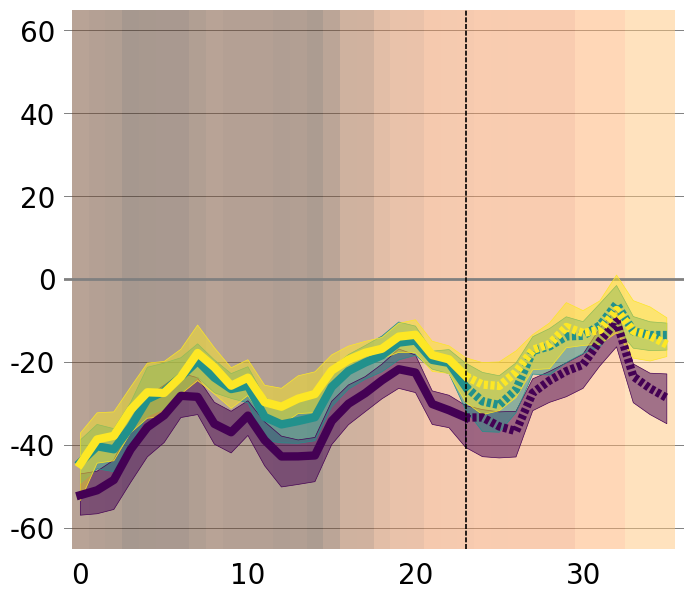

In [103]:
fig,ax = plt.subplots(figsize=(8,7))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

xmin, xmax = -1,36
ax.set_xlim([xmin, xmax])
# ymin, ymax = -85, 85
ymin, ymax = -65, 65
ax.set_ylim([ymin, ymax])

# xticks = []
# xticks_labels = ['April 2020', 'Oct 2020', 'April 2021', 'Oct 2021', 'April 2022']
# for i in range(int(xmin), int(xmax)):
#     if i%6 == 0:
#         xticks.append(i+.25)
# ax.set_xticks(xticks, xticks_labels)
# ax.tick_params(axis = 'x', bottom=True, labelsize = 15, pad=6, rotation=90)
ax.plot([23,23],[ymin,ymax], color='k', lw=1.2, zorder=200, linestyle='--', dashes=(3, 1))
    
yticks = []
for i in range(int(ymin), int(ymax)):
    if i%20 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 20, pad=6, rotation=0)

gdf_admin_mov = gdf_admin_mov.sort_values(by = ['rdi'], ascending=True).reset_index(drop=True)

n_clusters = 3
gdf_admin_mov['percentile'] = pd.qcut(gdf_admin_mov['rdi'], q=n_clusters, labels=[i+1 for i in range(n_clusters)])

clusters_average = []
clusters_lower = []
clusters_upper = []
clusters_lower_fcst = []
clusters_upper_fcst = []
cluster_indices = np.array_split(np.arange(file_count), n_clusters)
for i in range(n_clusters):
    cluster_average = []
    cluster_lower = []
    cluster_upper = []
    cluster_lower_fcst = []
    cluster_upper_fcst = []
    for j in range(len(fcst_admins['0']['yhat'])):
        cluster_average.append(np.mean([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]]))
        cluster_lower.append(np.percentile([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]], 25))
        cluster_upper.append(np.percentile([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]], 75))
        cluster_lower_fcst.append(np.percentile([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]], 25))
        cluster_upper_fcst.append(np.percentile([fcst_admins[str(x)]['yhat'][j] for x in cluster_indices[i]], 75))
    clusters_average.append(cluster_average)
    clusters_lower.append(cluster_lower)
    clusters_upper.append(cluster_upper)
    clusters_lower_fcst.append(cluster_lower_fcst)
    clusters_upper_fcst.append(cluster_upper_fcst)
    
viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(min(gdf_admin_mov['percentile']), max(gdf_admin_mov['percentile']))

x = np.arange(len(fcst_admins['0']))
x_obs = x[0:24]
x_fcst = x[23:]
    
for i in range(n_clusters):
    color = viridis(norm(i+1)) 
    y_smooth = pd.DataFrame({'y_smooth': clusters_average[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs = y_smooth[0:24]
    y_fcst = y_smooth[23:]
    ax.plot(x_obs, y_obs, color=color, zorder=100, lw=6)
    ax.plot(x_fcst, y_fcst, color=color, zorder=100, lw=6, linestyle='--', dashes=(.5, .3))
    
for i in range(n_clusters):
    color = viridis(norm(i+1))
    y_smooth_lower = pd.DataFrame({'y_smooth': clusters_lower[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs_lower = np.array(y_smooth_lower['y_smooth'][0:24])
    y_smooth_upper = pd.DataFrame({'y_smooth': clusters_upper[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs_upper = np.array(y_smooth_upper['y_smooth'][0:24])
    ax.fill_between(x_obs, y_obs_lower, y_obs_upper, color=color, alpha=0.5, edgecolor=None, linewidth=0, zorder=i+1)
    ax.fill_between(x_obs, y_obs_lower, y_obs_upper, color='None', alpha=1, edgecolor=color, linewidth=.5, zorder=1+2)

    y_smooth_lower_fcst = pd.DataFrame({'y_smooth': clusters_lower_fcst[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs_lower_fcst = np.array(y_smooth_lower_fcst['y_smooth'][23:])
    y_smooth_upper_fcst = pd.DataFrame({'y_smooth': clusters_upper_fcst[i]}).apply(savgol_filter,  window_length=4, polyorder=2)
    y_obs_upper_fcst = np.array(y_smooth_upper_fcst['y_smooth'][23:])
    ax.fill_between(x_fcst, y_obs_lower_fcst, y_obs_upper_fcst, color=color, alpha=0.5, edgecolor=None, linewidth=0, zorder=i+1)
    ax.fill_between(x_fcst, y_obs_lower_fcst, y_obs_upper_fcst, color='None', alpha=1, edgecolor=color, linewidth=.5, zorder=1+2)

for k in range(len(x)):
    try:
        rgba = matplotlib.cm.copper(1-((stringencies[k]-min(stringencies))/max(stringencies))*3/4)
    except:
        rgba = matplotlib.cm.copper(1-((stringencies[k-1]-min(stringencies))/max(stringencies))*3/4)
    x = [k-.50, k+.50]
    ax.fill_between(x, 100*np.ones(len(x)), -100*np.ones(len(x)), color=rgba, alpha=0.5, edgecolor='None', linewidth=0, zorder=0)
    
ax.plot([xmin-1, xmax],[0,0], color='gray', lw=2, zorder=1)

# plt.savefig(wd + '/plots/figure-prediction-rdi/' + country + '_prediction_by_rdi.pdf', bbox_inches = 'tight')

plt.show()

In [101]:
stringencies

[75.92999999999999,
 79.13903225806452,
 81.02,
 89.56322580645165,
 88.2174193548387,
 87.5,
 87.5,
 81.01599999999998,
 76.03129032258067,
 79.17000000000002,
 79.17,
 79.17000000000002,
 82.03399999999996,
 80.65838709677416,
 84.71999999999997,
 73.82354838709675,
 58.48387096774193,
 58.14733333333332,
 44.15032258064517,
 39.102999999999994,
 38.70032258064515,
 29.86451612903226,
 29.448571428571427,
 28.958709677419346,
 27.016333333333325,
 27.143225806451618,
 27.038999999999998,
 26.960322580645155,
 26.893870967741936,
 26.84800000000001,
 14.300000000000004,
 13.971999999999998,
 13.889999999999997,
 0.0,
 0.0,
 0.0]